![Fixel Algorithms](https://fixelalgorithms.co/images/CCExt.png)

# <center> Deep Learning Methods </center>
## <center> Lecture 9 - Tips and Tricks </center>
### <center> CutOut (Random Erasing), Mixup, CutMix  </center>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/FixelAlgorithmsTeam/FixelCourses/blob/master/DeepLearningMethods/09_TipsAndTricks/MainImageAugmentation2.ipynb)

In [1]:
#-- Wide screen:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
#-- Auto reload:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib

import torch
import torchvision
import torchvision.transforms as transforms

In [4]:
def PlotTransofrm(lImages, title, bAxis=False):
    N     = len(lImages)
    width = 4
    
    fig, _ = plt.subplots(1, N, figsize=(N*width, 6))
    for ii, ax in enumerate(fig.axes):
        ax.imshow   (lImages[ii], cmap='gray')
        ax.set_title(f'{ii}')
        ax.axis('on') if bAxis else ax.axis('off')        
    
    plt.suptitle    (title)
    plt.tight_layout()

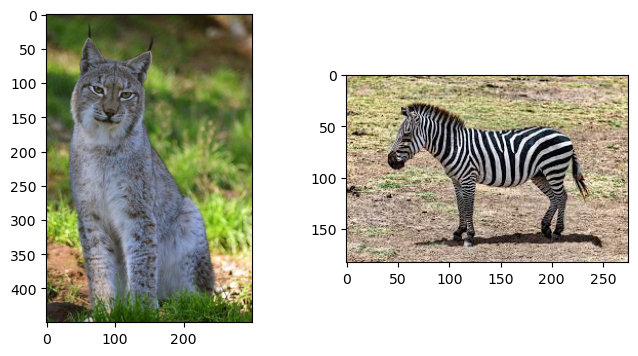

In [5]:
from PIL import Image

oImage1 = Image.open('./img1.jpg')
oImage2 = Image.open('./img2.jpg')

plt.figure (figsize=(8, 4))
plt.subplot(1,2,1).imshow(oImage1)
plt.subplot(1,2,2).imshow(oImage2)
plt.show   ()

### Random Erasing (CutOut)
Randomly selects a rectangle region in an torch Tensor image and erases its pixels.  
This transform does not support PIL Image.   

**Random Erasing paper:** https://arxiv.org/abs/1708.04896  
**CutOut paper:**         https://arxiv.org/pdf/1708.04552.pdf



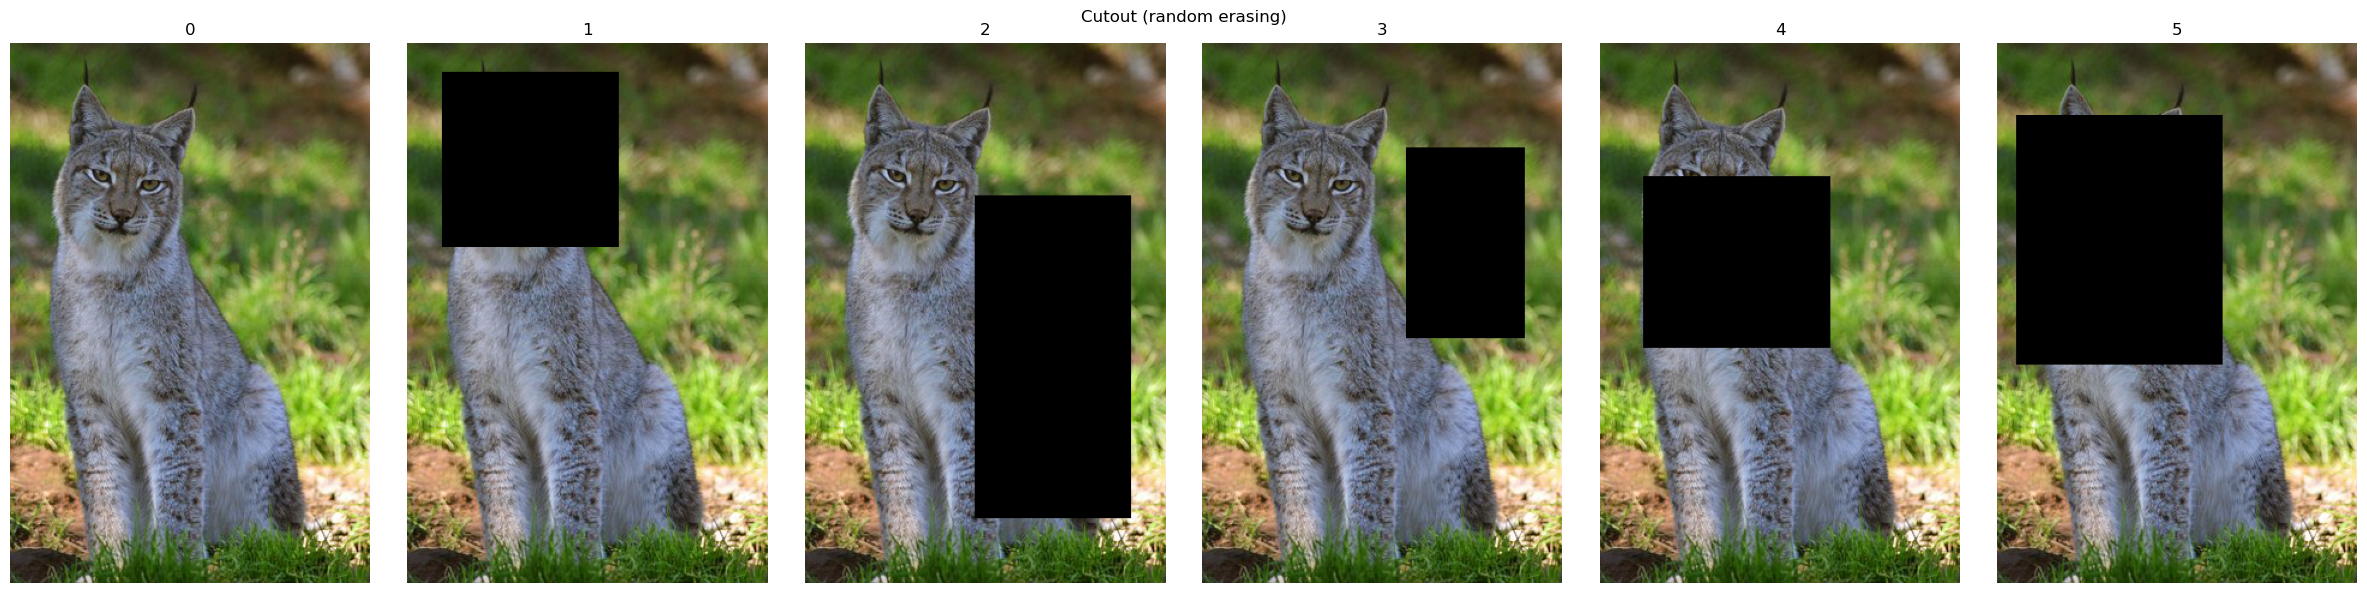

In [6]:
oRandomErasing = transforms.Compose([transforms.ToTensor(), transforms.RandomErasing(p=1, value=0), transforms.ToPILImage()])
lRandomErasing = [oImage1] + [oRandomErasing(oImage1) for _ in range(5)]
PlotTransofrm(lRandomErasing, 'Cutout (random erasing)')
plt.show     ()

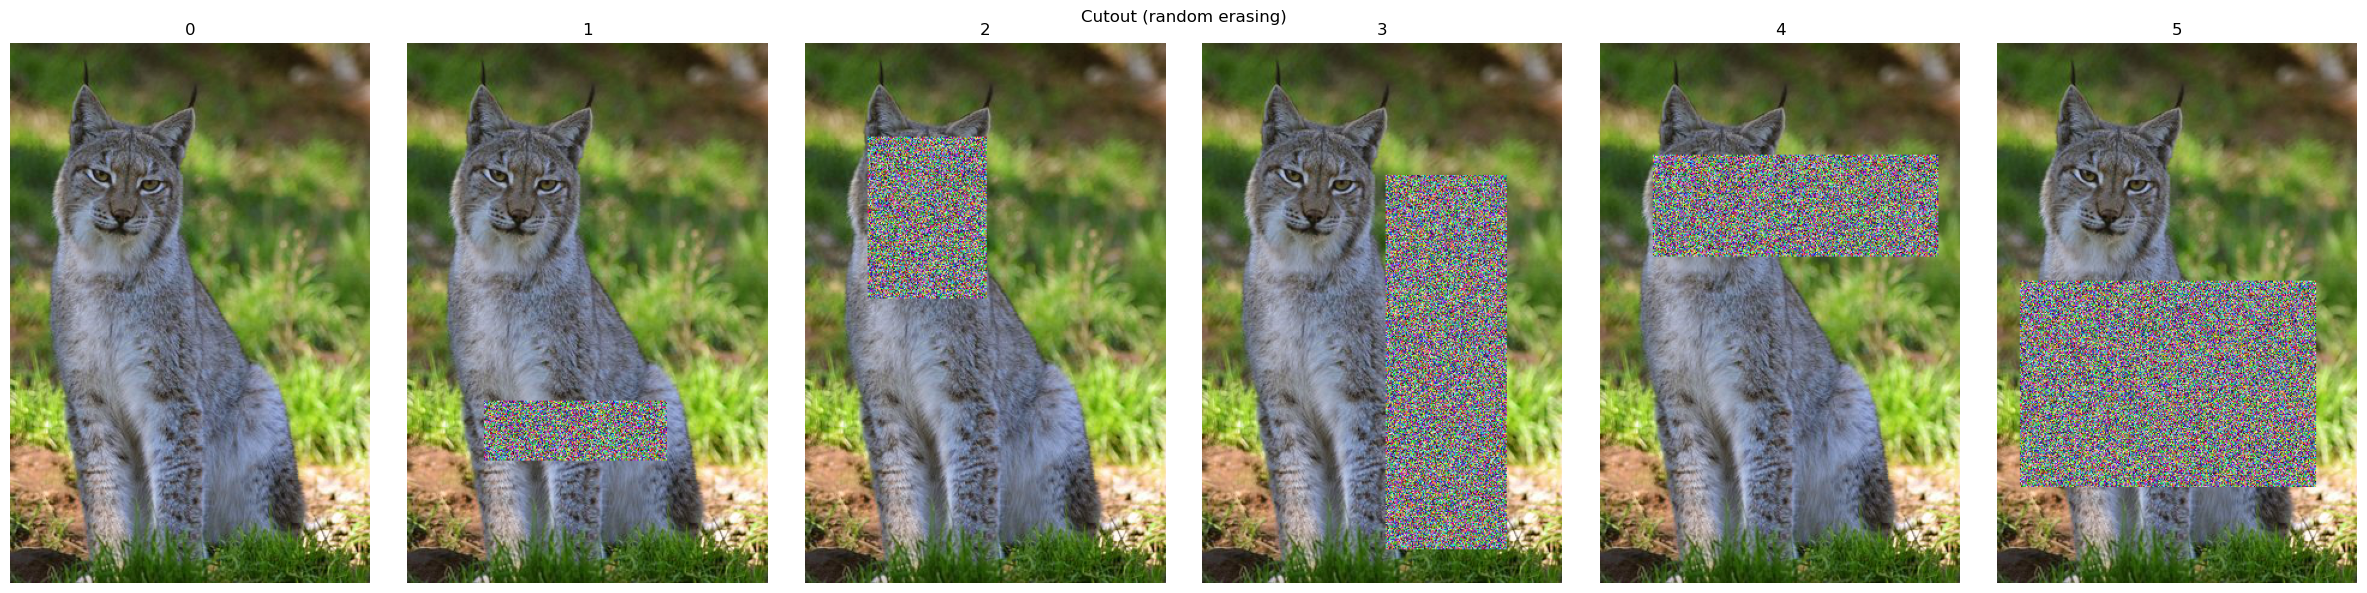

In [7]:
oRandomErasing = transforms.Compose([transforms.ToTensor(), transforms.RandomErasing(p=1, value='random'), transforms.ToPILImage()])
lRandomErasing = [oImage1] + [oRandomErasing(oImage1) for _ in range(5)]
PlotTransofrm(lRandomErasing, 'Cutout (random erasing)')
plt.show     ()

### Mixup

#### Beta distribution
https://en.wikipedia.org/wiki/Beta_distribution

In [8]:
from ipywidgets  import interact, FloatSlider, Layout
from scipy.stats import beta

def PlotBeta(α):
    xx = np.linspace(0, 1, 1001)
    vP = beta.pdf(xx, α, α)
    plt.plot (xx, vP, 'b', lw=2)
    plt.title(f'Beta($\\alpha={α}$, $\\beta={α}$)')
    plt.ylim ([0, 5])
    plt.grid ()
    plt.show ()

interact(PlotBeta, α=FloatSlider(min=0.05, max=1, step=.05, value=.5, layout=Layout(width='80%')));

interactive(children=(FloatSlider(value=0.5, description='α', layout=Layout(width='80%'), max=1.0, min=0.05, s…

#### Mixup
During training:
$$\lambda\sim\text{Beta}\left(\alpha,\alpha\right),\qquad\alpha\in\left[0,1\right]$$

In [9]:
oTransform = transforms.Compose([
    transforms.Resize    (256),
    transforms.CenterCrop(224),
    transforms.ToTensor  ()
])
mI1 = oTransform(oImage1)
mI2 = oTransform(oImage2)

def PlotMixup(λ):
    mI = λ * mI1 + (1 - λ) * mI2
    plt.imshow(mI.permute(1, 2, 0))
    plt.title (f'Mixup ($\\lambda={λ}$)')
    plt.show  ()

interact(PlotMixup, λ=FloatSlider(min=0.00, max=1, step=.05, value=0, layout=Layout(width='80%')));

interactive(children=(FloatSlider(value=0.0, description='λ', layout=Layout(width='80%'), max=1.0, step=0.05),…

#### CutMix
During training:
$$\lambda\sim\text{Beta}\left(\alpha,\alpha\right),\qquad\alpha\in\left[0,1\right]$$

In [10]:
def RandBox(W, H, λ):

    xCenter = np.random.randint(W)
    yCenter = np.random.randint(H)
    
    ratio = np.sqrt (1 - λ)
    w     = np.int32(W * ratio)
    h     = np.int32(H * ratio)

    xLow  = np.maximum(xCenter - w//2, 0)
    yLow  = np.maximum(yCenter - h//2, 0)
    xHigh = np.minimum(xCenter + w//2, W)
    yHigh = np.minimum(yCenter + h//2, H)

    return xLow, yLow, xHigh, yHigh

In [11]:
def CutMix(mI1, mI2, α):
    λ                           = np.random.beta(α, α)
    xLow, yLow, xHigh, yHigh    = RandBox(*mI1.shape[1:], λ)
    mI                          = mI1.clone()
    mI[:,xLow:xHigh,yLow:yHigh] = mI2[:,xLow:xHigh,yLow:yHigh]
    
    #-- Adjust λ to match the pixel ratio:
    λ2 = 1 - ((xHigh - xLow) * (yHigh - yLow) / (mI1.shape[1] * mI1.shape[2]))
        
    return mI

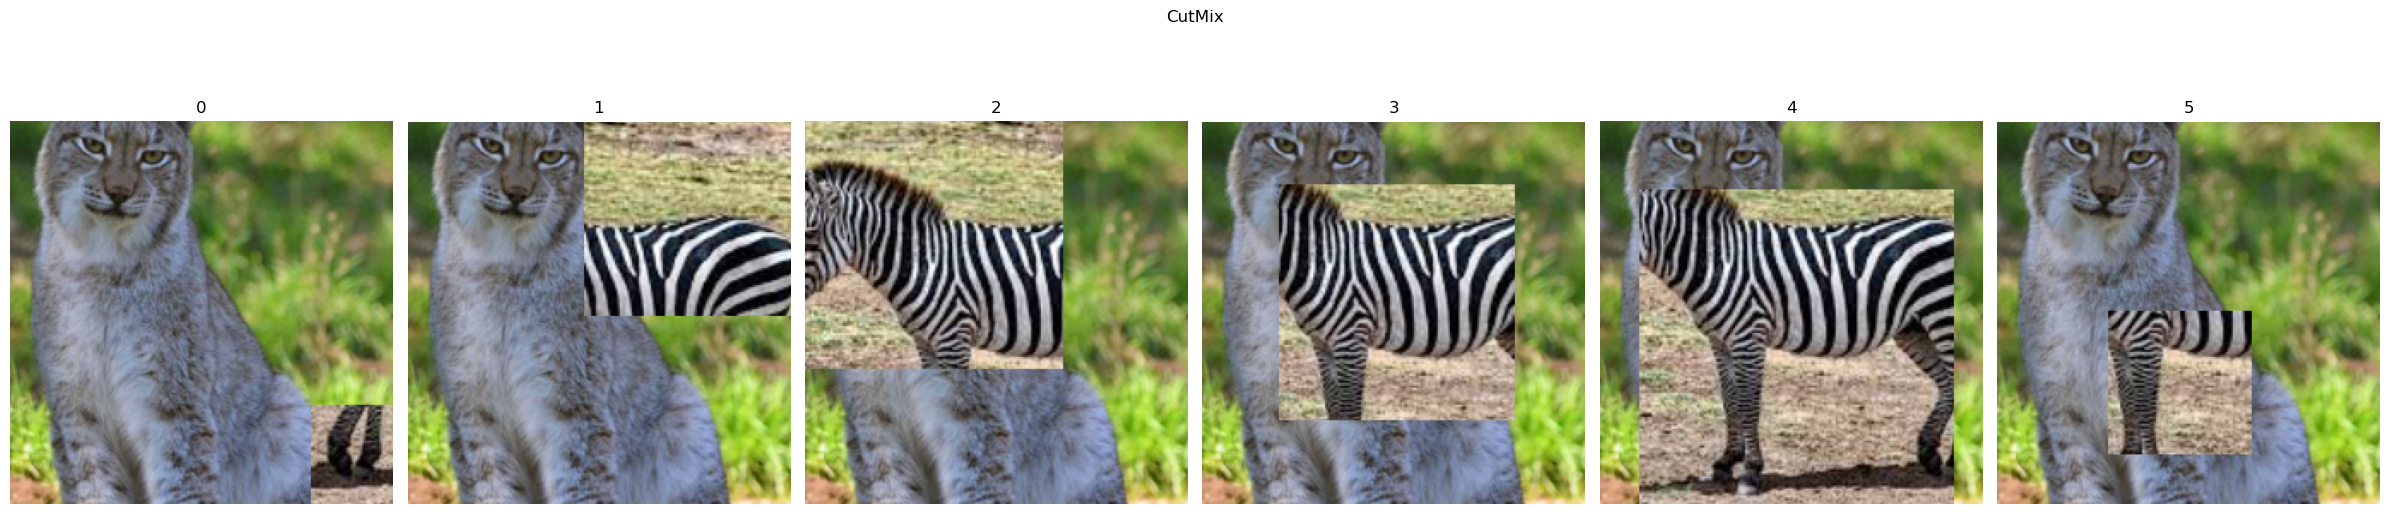

In [12]:
mI1    = oTransform(oImage1)
mI2    = oTransform(oImage2)
lMixup = [CutMix(mI1, mI2, 1).permute(1, 2, 0) for _ in range(6)]
PlotTransofrm(lMixup, 'CutMix')
plt.show     ()